In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib
import ipywidgets as widgets

In [2]:
# --- inputs ---
#base = "2Dresults/shortpulse/"
base = "review2DSimulation/"
ROI = np.load("ROIs/erode_C4ROI3D.npy")

datasetsshort = [ "focused0p2mmonepulse", "focused0p5mmonepulse", "planar0p2mmonepulse", "planar0p5mmonepulse"]
datasetsconti = ["planar0p2mmcontinuous","planar0p5mmcontinuous", "focused0p2mmcontinuous", "focused0p5mmcontinuous"]

methodtype = ["Mesh","Linear","NN"]
grids = ["0p2mm", "0p5mm"]
SLICE_INDEX_LIST  = [i for i in range(86,121)]

L2short = {d: {m: [] for m in methodtype} for d in datasetsshort}
L1short = {d: {m: [] for m in methodtype} for d in datasetsshort}
peak_diff = {d: {m: [] for m in methodtype} for d in datasetsshort}
focal_dist = {d: {m: [] for m in methodtype} for d in datasetsshort}
L2conti = {d: {m: [] for m in methodtype} for d in datasetsconti}
L1conti = {d: {m: [] for m in methodtype} for d in datasetsconti}

for s in SLICE_INDEX_LIST:
    print(s)
    for ds in datasetsshort:
        gtfile = base + "GroundTruth"  + "_slice" + str(s) + ds +"_PeakPressure.npy"
        GT = np.load(gtfile)
        RGT = np.where(ROI[:, :, s], GT, 0)
        idx = np.argmax(RGT)
        px, py= np.unravel_index(idx, RGT.shape)
        for m in methodtype:
            simfile = base + m + "_slice" + str(s) + ds + "_PeakPressure.npy"
            thissimulation = np.load(simfile)
            R = np.where(ROI[:, :, s], thissimulation, 0)
            idx = np.argmax(R)
            pxx, pyy = np.unravel_index(idx, R.shape)
            
            l2 = np.sum((RGT - R) ** 2)/np.sum(RGT ** 2)
            l1 = np.max(np.abs(np.abs(RGT) - np.abs(R)))/np.max(np.abs(RGT))
            focal = np.abs(np.max(np.abs(R)) - np.max(np.abs(RGT))) / np.max(np.abs(RGT))
            dist = np.sqrt((px - pxx)**2 + (py - pyy)**2) * 0.1
            
            L2short[ds][m].append(l2 * 100)
            L1short[ds][m].append(l1 * 100)
            peak_diff[ds][m].append(focal)
            focal_dist[ds][m].append(dist)
            
    for ds in datasetsconti:
        gtfile = base + "GroundTruth"  + "_slice" + str(s) + ds +"_steadywave.npy"
        GT = np.load(gtfile)
        RGT = np.where(ROI[:, :, s], GT, 0)
        for m in methodtype:
            simfile = base + m + "_slice" + str(s) + ds + "_steadywave.npy"
            thissimulation = np.load(simfile)
            R = np.where(ROI[:, :, s], thissimulation, 0)
            
            l2 = np.sum((RGT - R) ** 2)/np.sum(RGT ** 2)
            l1 = np.max(np.abs(np.abs(RGT) - np.abs(R)))/np.max(np.abs(RGT))
            
            L2conti[ds][m].append(l2 * 100)
            L1conti[ds][m].append(l1 * 100)

86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


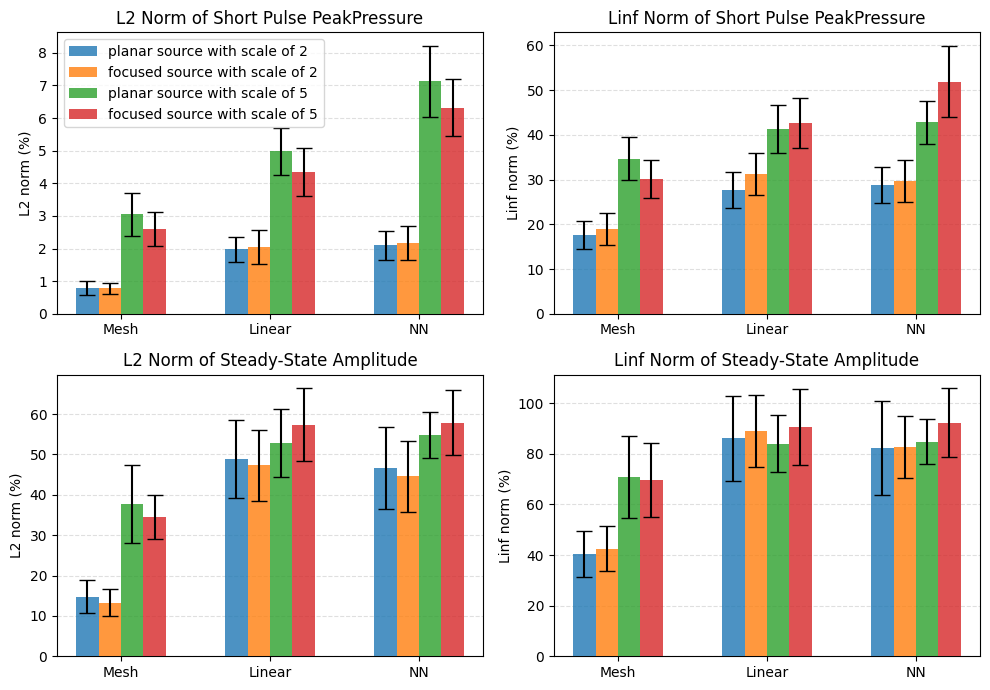

In [3]:
# --- aggregate stats ---# --- aggregate stats ---
subsetshort = ["planar0p2mmonepulse","focused0p2mmonepulse",  "planar0p5mmonepulse", "focused0p5mmonepulse"]
subsetconti = ["planar0p2mmcontinuous", "focused0p2mmcontinuous", "planar0p5mmcontinuous", "focused0p5mmcontinuous"]
L2shortmeans = {d: [np.mean(L2short[d][m]) for m in methodtype] for d in subsetshort}
L2shortstds  = {d: [np.std( L2short[d][m], ddof=1) for m in methodtype] for d in subsetshort}
L1shortmeans = {d: [np.mean(L1short[d][m]) for m in methodtype] for d in subsetshort}
L1shortstds  = {d: [np.std( L1short[d][m], ddof=1) for m in methodtype] for d in subsetshort}
L2contimeans = {d: [np.mean(L2conti[d][m]) for m in methodtype] for d in subsetconti}
L2contistds  = {d: [np.std( L2conti[d][m], ddof=1) for m in methodtype] for d in subsetconti}
L1contimeans = {d: [np.mean(L1conti[d][m]) for m in methodtype] for d in subsetconti}
L1contistds  = {d: [np.std( L1conti[d][m], ddof=1) for m in methodtype] for d in subsetconti}

x = np.arange(len(methodtype))
width = 0.15  # bar width
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
subsetnames = [
    "planar source with scale of 2",
    "focused source with scale of 2",
    "planar source with scale of 5",
    "focused source with scale of 5",
]

for i, dname in enumerate(subsetshort):
    offset = (i - (len(subsetshort) - 1) / 2) * width  # centers bars nicely
    label = subsetnames[i] if i < len(subsetnames) else str(dname)

    ax[0,0].bar(x + offset, L2shortmeans[dname], width, yerr=L2shortstds[dname], capsize=6, label=label, alpha=0.8, zorder=3)
    ax[0,1].bar(x + offset, L1shortmeans[dname], width, yerr=L1shortstds[dname], capsize=6, label=label, alpha=0.8, zorder=3)

for i, dname in enumerate(subsetconti):
    offset = (i - (len(subsetshort) - 1) / 2) * width  # centers bars nicely
    label = subsetnames[i] if i < len(subsetnames) else str(dname)

    ax[1,0].bar(x + offset, L2contimeans[dname], width, yerr=L2contistds[dname], capsize=6, label=label, alpha=0.8, zorder=3)
    ax[1,1].bar(x + offset, L1contimeans[dname], width, yerr=L1contistds[dname], capsize=6, label=label, alpha=0.8, zorder=3)

ax[0,0].set_xticks(x)
ax[0,0].set_xticklabels(methodtype, rotation=0)
ax[0,0].set_ylabel("L2 norm (%)")
ax[0,0].set_title("L2 Norm of Short Pulse PeakPressure")
ax[0,0].set_axisbelow(True)
ax[0,0].grid(axis="y", linestyle="--", alpha=0.4, zorder=0)
ax[0,0].legend(loc="upper left")

ax[0,1].set_xticks(x)
ax[0,1].set_xticklabels(methodtype, rotation=0)
ax[0,1].set_ylabel("Linf norm (%)")
ax[0,1].set_title("Linf Norm of Short Pulse PeakPressure")
ax[0,1].set_axisbelow(True)
ax[0,1].grid(axis="y", linestyle="--", alpha=0.4, zorder=0)
#ax[0,1].legend(loc="upper left")

ax[1,0].set_xticks(x)
ax[1,0].set_xticklabels(methodtype, rotation=0)
ax[1,0].set_ylabel("L2 norm (%)")
ax[1,0].set_title("L2 Norm of Steady-State Amplitude")
ax[1,0].set_axisbelow(True)
ax[1,0].grid(axis="y", linestyle="--", alpha=0.4, zorder=0)
#ax[1,0].legend(loc="upper left")

ax[1,1].set_xticks(x)
ax[1,1].set_xticklabels(methodtype, rotation=0)
ax[1,1].set_ylabel("Linf norm (%)")
ax[1,1].set_title("Linf Norm of Steady-State Amplitude")
ax[1,1].set_axisbelow(True)
ax[1,1].grid(axis="y", linestyle="--", alpha=0.4, zorder=0)
#ax[1,1].legend(loc="upper left")

plt.tight_layout()
plt.savefig("2DBarchart.svg", dpi=300, bbox_inches='tight')
plt.show()




In [6]:
import pandas as pd
from scipy.stats import shapiro, ttest_rel, wilcoxon

def stattest(data, subset):
    rows = []
    for d in subset:
        target = np.asarray(data[d]["Mesh"], float)
    
        pvals = []
        tmp = []
    
        for m in methodtype:
            if m == "Mesh":
                continue
    
            other = np.asarray(data[d][m], float)
    
            # paired, drop NaNs
            mask = np.isfinite(target) & np.isfinite(other)
            a, b = target[mask], other[mask]
            if len(a) < 3:
                continue
    
            diff = a - b  # negative => Mesh better
    
            sh_p = shapiro(diff).pvalue
    
            if sh_p >= 0.05:
                stat, p = ttest_rel(a, b)
                test = "paired_t"
                effect = diff.mean() / diff.std(ddof=1)  # Cohen's dz
            else:
                stat, p = wilcoxon(a, b)
                test = "wilcoxon"
                effect = 1 - (2 * stat) / (len(diff) * (len(diff) + 1))       # simple r approx
                #effect = diff.mean() / diff.std(ddof=1)  # Cohen's dz
            tmp.append((m, a.mean(), b.mean(), a.std(ddof=1), b.std(ddof=1), diff.mean(), sh_p, test, stat, p, effect))
            pvals.append(p)
    
        # Bonferroni correction (simple and explicit)
        pvals = np.array(pvals)
        p_corr = np.minimum(pvals * len(pvals), 1.0)
    
        for (m, mt, mo, stdt, stdo, md, sh_p, test, stat, p, eff), pc in zip(tmp, p_corr):
            rows.append({
                "condition": d,
                "method": m,
                "mean_mesh": mt,
                "mean_other": mo,
                "std_mesh": stdt,
                "std_other": stdo,
                "mean_diff": md,
                "shapiro_p": sh_p,
                "test": test,
                "stat": stat,
                "p": p,
                "p_bonf": pc,
                "significant": pc < 0.05,
                "effect_size": eff
            })
    
    df = pd.DataFrame(rows)
    #display(df)
    return df
display(stattest(L2short, subsetshort))
display(stattest(L1short, subsetshort))
display(stattest(L2conti, subsetconti))
display(stattest(L1conti, subsetconti))
display(stattest(peak_diff, subsetshort))
display(stattest(focal_dist, subsetshort))


,condition,method,mean_mesh,mean_other,std_mesh,std_other,mean_diff,shapiro_p,test,stat,p,p_bonf,significant,effect_size
0,planar0p2mmonepulse,Linear,0.791266,1.979103,0.203056,0.384561,-1.187837,0.993627,paired_t,-22.922200,2.946766e-22,5.893533e-22,True,-3.874559
1,planar0p2mmonepulse,NN,0.791266,2.102830,0.203056,0.444418,-1.311564,0.478200,paired_t,-23.278638,1.797932e-22,3.595864e-22,True,-3.934808
2,focused0p2mmonepulse,Linear,0.779209,2.049172,0.164277,0.519722,-1.269963,0.005543,wilcoxon,0.000000,5.820766e-11,1.164153e-10,True,1.000000
3,focused0p2mmonepulse,NN,0.779209,2.161321,0.164277,0.519001,-1.382112,0.020725,wilcoxon,0.000000,5.820766e-11,1.164153e-10,True,1.000000
4,planar0p5mmonepulse,Linear,3.048055,4.978060,0.666058,0.718060,-1.930006,0.981385,paired_t,-16.709347,5.789240e-18,1.157848e-17,True,-2.824395
5,planar0p5mmonepulse,NN,3.048055,7.119310,0.666058,1.095740,-4.071256,0.534601,paired_t,-17.691991,1.008091e-18,2.016181e-18,True,-2.990492
6,focused0p5mmonepulse,Linear,2.597324,4.343623,0.526867,0.724019,-1.746299,0.582910,paired_t,-14.725615,2.558875e-16,5.117750e-16,True,-2.489083
7,focused0p5mmonepulse,NN,2.597324,6.314950,0.526867,0.874851,-3.717626,0.276024,paired_t,-20.019831,2.157736e-20,4.315473e-20,True,-3.383969


,condition,method,mean_mesh,mean_other,std_mesh,std_other,mean_diff,shapiro_p,test,stat,p,p_bonf,significant,effect_size
0,planar0p2mmonepulse,Linear,17.626652,27.678280,3.101208,3.964361,-10.051628,0.256164,paired_t,-12.635843,2.126593e-14,4.253187e-14,True,-2.135847
1,planar0p2mmonepulse,NN,17.626652,28.761724,3.101208,4.036353,-11.135072,0.148649,paired_t,-13.195512,6.211065e-15,1.242213e-14,True,-2.230449
2,focused0p2mmonepulse,Linear,18.980802,31.238094,3.605648,4.678528,-12.257292,0.034700,wilcoxon,0.000000,5.820766e-11,1.164153e-10,True,1.000000
3,focused0p2mmonepulse,NN,18.980802,29.643762,3.605648,4.683135,-10.662960,0.554619,paired_t,-12.815111,1.428149e-14,2.856297e-14,True,-2.166149
4,planar0p5mmonepulse,Linear,34.709867,41.289764,4.745337,5.298269,-6.579897,0.466132,paired_t,-6.884352,6.269065e-08,1.253813e-07,True,-1.163668
5,planar0p5mmonepulse,NN,34.709867,42.805922,4.745337,4.848506,-8.096055,0.901919,paired_t,-9.451988,4.840877e-11,9.681754e-11,True,-1.597678
6,focused0p5mmonepulse,Linear,30.155467,42.611514,4.256332,5.545736,-12.456047,0.687705,paired_t,-11.728461,1.691382e-13,3.382764e-13,True,-1.982472
7,focused0p5mmonepulse,NN,30.155467,51.920228,4.256332,8.021594,-21.764760,0.004283,wilcoxon,0.000000,5.820766e-11,1.164153e-10,True,1.000000


,condition,method,mean_mesh,mean_other,std_mesh,std_other,mean_diff,shapiro_p,test,stat,p,p_bonf,significant,effect_size
0,planar0p2mmcontinuous,Linear,14.771111,48.861418,4.148213,9.690904,-34.090307,0.226059,paired_t,-26.282294,3.586739e-24,7.173478e-24,True,-4.442518
1,planar0p2mmcontinuous,NN,14.771111,46.579579,4.148213,10.117717,-31.808468,0.102093,paired_t,-23.715764,9.898396e-23,1.979679e-22,True,-4.008696
2,focused0p2mmcontinuous,Linear,13.252004,47.285745,3.381441,8.761814,-34.033741,0.477976,paired_t,-24.282279,4.633210e-23,9.266421e-23,True,-4.104454
3,focused0p2mmcontinuous,NN,13.252004,44.606810,3.381441,8.794532,-31.354805,0.020054,wilcoxon,0.000000,5.820766e-11,1.164153e-10,True,1.000000
4,planar0p5mmcontinuous,Linear,37.742607,52.897327,9.744378,8.386053,-15.154720,0.567436,paired_t,-12.685687,1.903030e-14,3.806060e-14,True,-2.144272
5,planar0p5mmcontinuous,NN,37.742607,54.748017,9.744378,5.696410,-17.005410,0.004721,wilcoxon,5.000000,5.820766e-10,1.164153e-09,True,0.992063
6,focused0p5mmcontinuous,Linear,34.510461,57.399373,5.544182,9.008360,-22.888912,0.233532,paired_t,-19.904246,2.587988e-20,5.175976e-20,True,-3.364432
7,focused0p5mmcontinuous,NN,34.510461,57.818686,5.544182,8.030930,-23.308225,0.926796,paired_t,-21.093580,4.153905e-21,8.307809e-21,True,-3.565466


,condition,method,mean_mesh,mean_other,std_mesh,std_other,mean_diff,shapiro_p,test,stat,p,p_bonf,significant,effect_size
0,planar0p2mmcontinuous,Linear,40.441749,86.137251,9.027715,16.863158,-45.695502,0.026880,wilcoxon,0.000000,5.820766e-11,1.164153e-10,True,1.000000
1,planar0p2mmcontinuous,NN,40.441749,82.365312,9.027715,18.548315,-41.923563,0.456178,paired_t,-17.147116,2.631115e-18,5.262230e-18,True,-2.898392
2,focused0p2mmcontinuous,Linear,42.515921,89.227216,8.949011,14.242409,-46.711295,0.343376,paired_t,-19.956950,2.381816e-20,4.763633e-20,True,-3.373340
3,focused0p2mmcontinuous,NN,42.515921,82.743501,8.949011,12.128269,-40.227580,0.085879,paired_t,-18.722196,1.751682e-19,3.503364e-19,True,-3.164629
4,planar0p5mmcontinuous,Linear,70.898614,83.991195,16.082860,11.185936,-13.092582,0.734383,paired_t,-6.140087,5.669425e-07,1.133885e-06,True,-1.037864
5,planar0p5mmcontinuous,NN,70.898614,84.850344,16.082860,8.793620,-13.951731,0.051602,paired_t,-5.336808,6.274039e-06,1.254808e-05,True,-0.902085
6,focused0p5mmcontinuous,Linear,69.623414,90.723173,14.756230,15.042131,-21.099759,0.701096,paired_t,-10.393733,4.299322e-12,8.598643e-12,True,-1.756862
7,focused0p5mmcontinuous,NN,69.623414,92.403815,14.756230,13.547775,-22.780401,0.460455,paired_t,-13.917570,1.336722e-15,2.673444e-15,True,-2.352499


,condition,method,mean_mesh,mean_other,std_mesh,std_other,mean_diff,shapiro_p,test,stat,p,p_bonf,significant,effect_size
0,planar0p2mmonepulse,Linear,0.039173,0.054503,0.038243,0.043297,-0.015330,0.556512,paired_t,-2.198648,0.034807,0.069614,False,-0.371639
1,planar0p2mmonepulse,NN,0.039173,0.063468,0.038243,0.046013,-0.024295,0.309146,paired_t,-3.135054,0.003532,0.007064,True,-0.529921
2,focused0p2mmonepulse,Linear,0.027141,0.031054,0.022276,0.025414,-0.003914,0.165380,paired_t,-0.999924,0.324411,0.648821,False,-0.169018
3,focused0p2mmonepulse,NN,0.027141,0.032348,0.022276,0.028518,-0.005208,0.344153,paired_t,-1.061216,0.296072,0.592144,False,-0.179378
4,planar0p5mmonepulse,Linear,0.113781,0.119466,0.068504,0.066046,-0.005684,0.260445,paired_t,-0.488238,0.628515,1.000000,False,-0.082527
5,planar0p5mmonepulse,NN,0.113781,0.122634,0.068504,0.085897,-0.008853,0.002454,wilcoxon,305.000000,0.877899,1.000000,False,0.515873
6,focused0p5mmonepulse,Linear,0.052490,0.069817,0.041351,0.058083,-0.017327,0.584589,paired_t,-1.867514,0.070470,0.140940,False,-0.315667
7,focused0p5mmonepulse,NN,0.052490,0.080125,0.041351,0.070744,-0.027635,0.596440,paired_t,-2.220938,0.033121,0.066241,False,-0.375407


,condition,method,mean_mesh,mean_other,std_mesh,std_other,mean_diff,shapiro_p,test,stat,p,p_bonf,significant,effect_size
0,planar0p2mmonepulse,Linear,0.212120,0.204172,0.164957,0.134053,0.007949,8.999750e-05,wilcoxon,130.0,0.566060,1.000000,False,0.793651
1,planar0p2mmonepulse,NN,0.212120,0.299997,0.164957,0.512206,-0.087877,9.328794e-12,wilcoxon,141.0,0.796733,1.000000,False,0.776190
2,focused0p2mmonepulse,Linear,0.851075,1.365201,2.428680,2.737259,-0.514127,1.836676e-10,wilcoxon,23.0,0.000105,0.000210,True,0.963492
3,focused0p2mmonepulse,NN,0.851075,1.388949,2.428680,2.710267,-0.537875,2.664270e-10,wilcoxon,32.5,0.000038,0.000076,True,0.948413
4,planar0p5mmonepulse,Linear,0.225480,0.590401,0.174099,1.132020,-0.364921,4.149559e-10,wilcoxon,85.5,0.064581,0.129163,False,0.864286
5,planar0p5mmonepulse,NN,0.225480,1.096038,0.174099,1.393203,-0.870558,1.321506e-06,wilcoxon,54.0,0.000019,0.000038,True,0.914286
6,focused0p5mmonepulse,Linear,1.033876,1.255270,2.159102,2.093199,-0.221394,3.499158e-06,wilcoxon,71.0,0.041334,0.082668,False,0.887302
7,focused0p5mmonepulse,NN,1.033876,1.622476,2.159102,1.978599,-0.588600,4.011740e-02,wilcoxon,145.0,0.043485,0.086969,False,0.769841


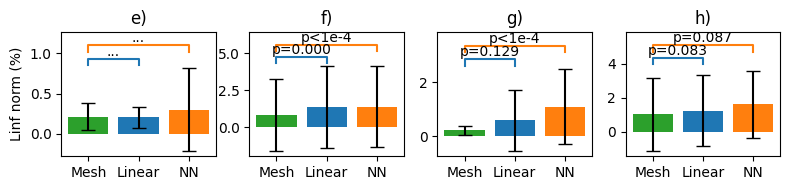

In [7]:
def plot_stats_subplots(df, order=("Mesh","Linear", "NN")):
    conditions = list(df["condition"].unique())
    COLORS = {
    "Linear": "#1f77b4",  # blue
    "Mesh":   "#2ca02c",  # green
    "NN":     "#ff7f0e",  # orange
    }

    fig, axes = plt.subplots(1, 4, figsize=(8, 2), squeeze=True)
    axes = axes.ravel()

    def add_bracket(ax, x1, x2, y, h, text):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5)
        ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom")

    for i, cond in enumerate(conditions):
        ax = axes[i]
        sub = df[df["condition"] == cond]
        label = ["e)", "f)", "g)", "h)"]

        # Pull means
        mesh = sub["mean_mesh"].iloc[0] 
        linear = sub.loc[sub["method"] == "Linear", "mean_other"].iloc[0] if (sub["method"] == "Linear").any() else np.nan
        nn = sub.loc[sub["method"] == "NN", "mean_other"].iloc[0] if (sub["method"] == "NN").any() else np.nan
        means = {"Mesh": mesh, "Linear": linear, "NN": nn}

        mesh_std = sub["std_mesh"].iloc[0] 
        linear_std = sub.loc[sub["method"] == "Linear", "std_other"].iloc[0] if (sub["method"] == "Linear").any() else np.nan
        nn_std = sub.loc[sub["method"] == "NN", "std_other"].iloc[0] if (sub["method"] == "NN").any() else np.nan
        stds = {"Mesh": mesh_std, "Linear": linear_std, "NN": nn_std}
        
        xs = np.arange(len(order))
        ys = [means[m] for m in order]
        sems = [stds[m] for m in order]

        ax.bar(xs, ys, yerr=sems, capsize=5, color=[COLORS[m] for m in order])
        ax.set_xticks(xs, order)
        ax.set_title(label[i])
        if i == 0:
            ax.set_ylabel("Linf norm (%)")

        p_lin = sub.loc[sub["method"] == "Linear", "p_bonf"]
        p_nn  = sub.loc[sub["method"] == "NN", "p_bonf"]

        y_top = np.max(ys) + np.max(sems)
        
        y = y_top * 1.05
        h = (y_top * 0.1)
        #print(h)
        def fmt_p(p):
            if p < 1e-4:
                return f"p<1e-4"
            if p == 1:
                return "..."
            return f"p={p:.3f}"

        # map bar positions
        pos = {name: idx for idx, name in enumerate(order)}

        add_bracket(ax, pos["Mesh"], pos["Linear"], y, h, fmt_p(float(p_lin.iloc[0])))
        y += h * 2  # stack next bracket higher

        add_bracket(ax, pos["Mesh"], pos["NN"], y, h, fmt_p(float(p_nn.iloc[0])))

        ax.set_ylim(top=y + h*3)

    # turn off unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    return fig

methodtype = ["Linear", "Mesh", "NN"]
df = stattest(focal_dist, subsetshort)

plot_stats_subplots(df)
#plt.savefig("bigplotpart2.svg", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\omen\AppData\Local\Temp\ipykernel_24548\2050145261.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
D:\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\omen\AppData\Local\Temp\ipykernel_24548\2050145261.py:48: FutureWarni

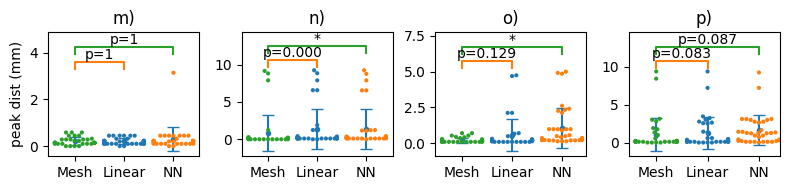

In [8]:
import seaborn as sns

def plot_stats_subplots(df, data, subset, order=("Mesh","Linear","NN")):  # <-- ADD data, subset
    conditions = list(df["condition"].unique())
    COLORS = {
        "Linear": "#1f77b4",  # blue
        "Mesh":   "#2ca02c",  # green
        "NN":     "#ff7f0e",  # orange
    }

    fig, axes = plt.subplots(1, 4, figsize=(8, 2), squeeze=True)
    axes = axes.ravel()

    def add_bracket(ax, x1, x2, y, h, text):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5)
        ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom")

    for i, cond in enumerate(conditions):
        ax = axes[i]
        sub = df[df["condition"] == cond]
        label = ["m)", "n)", "o)", "p)"]

        # ---- SWARM DATA (minimal addition) ----
        rows = []
        for m in order:
            arr = np.asarray(data[cond][m], float)
            arr = arr[np.isfinite(arr)]
            rows.extend([(m, v) for v in arr])
        swarm_df = pd.DataFrame(rows, columns=["method", "value"])
        # --------------------------------------

        # Pull means (keep your summary means)
        mesh = sub["mean_mesh"].iloc[0]
        linear = sub.loc[sub["method"] == "Linear", "mean_other"].iloc[0] if (sub["method"] == "Linear").any() else np.nan
        nn = sub.loc[sub["method"] == "NN", "mean_other"].iloc[0] if (sub["method"] == "NN").any() else np.nan
        means = {"Mesh": mesh, "Linear": linear, "NN": nn}

        mesh_std = sub["std_mesh"].iloc[0]
        linear_std = sub.loc[sub["method"] == "Linear", "std_other"].iloc[0] if (sub["method"] == "Linear").any() else np.nan
        nn_std = sub.loc[sub["method"] == "NN", "std_other"].iloc[0] if (sub["method"] == "NN").any() else np.nan
        stds = {"Mesh": mesh_std, "Linear": linear_std, "NN": nn_std}

        xs = np.arange(len(order))
        ys = [means[m] for m in order]
        sems = [stds[m] for m in order]

        # ---- REPLACE BAR WITH SWARM (minimal change) ----
        sns.swarmplot(
            data=swarm_df, x="method", y="value",
            order=order, palette=COLORS,
            ax=ax, size=3
        )
        # Optional: overlay mean ± error (keeps your "error bar" idea)
        ax.errorbar(xs, ys, yerr=sems, fmt=".", capsize=4)
        # -------------------------------------------------

        ax.set_xticks(xs, order)
        ax.set_title(label[i])
        ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel("peak dist (mm)")
        else:
            ax.set_ylabel("")

        p_lin = sub.loc[sub["method"] == "Linear", "p_bonf"]
        p_nn  = sub.loc[sub["method"] == "NN", "p_bonf"]

        y_top = max(np.nanmax(swarm_df["value"].values), np.nanmax(ys) + np.nanmax(sems))
        y = y_top * 1.05
        h = y_top * 0.1

        def fmt_p(p):
            if p < 1e-4:
                return f"*"
            if p == 1:
                return "p=1"
            return f"p={p:.3f}"

        pos = {name: idx for idx, name in enumerate(order)}

        add_bracket(ax, pos["Mesh"], pos["Linear"], y, h, fmt_p(float(p_lin.iloc[0])))
        y += h * 2
        add_bracket(ax, pos["Mesh"], pos["NN"], y, h, fmt_p(float(p_nn.iloc[0])))

        ax.set_ylim(top=y + h*3)

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    return fig

methodtype = ["Linear", "Mesh", "NN"]
df = stattest(focal_dist, subsetshort)

plot_stats_subplots(df, focal_dist, subsetshort)
#plt.savefig("bigplotpart4_errorbar.svg", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
base = "review3DSimulation/3Dsimulation_"
ROI = np.load("ROIs/erode_C4ROI3D.npy")

datasetsshort = ["0p2mm_focused_onepulse", "0p2mm_planar_onepulse", "0p5mm_focused_onepulse", "0p5mm_planar_onepulse"]
datasetsconti = ["0p2mm_focused_continuous", "0p2mm_planar_continuous", "0p5mm_focused_continuous", "0p5mm_planar_continuous"]

methodtype = ["Mesh_","Linear_","NN_"]
grids = ["0p2mm", "0p5mm"]

L2short3D = {d: {m: [] for m in methodtype} for d in datasetsshort}
L1short3D = {d: {m: [] for m in methodtype} for d in datasetsshort}
peak_diff3D = {d: {m: [] for m in methodtype} for d in datasetsshort}
focal_dist3D = {d: {m: [] for m in methodtype} for d in datasetsshort}
L2conti3D = {d: {m: [] for m in methodtype} for d in datasetsconti}
L1conti3D = {d: {m: [] for m in methodtype} for d in datasetsconti}

for ds in datasetsshort:
    gtfile = base + "GroundTruth_" + ds +".npy"
    GT = np.load(gtfile)
    RGT = np.full(ROI.shape, 0, dtype=float)
    RGT[ROI>0] = GT
    idx = np.argmax(RGT)
    px, py, pz = np.unravel_index(idx, ROI.shape)
    
    for m in methodtype:
        simfile = base + m + ds + ".npy"
        thissimulation = np.load(simfile)
        R = np.full(ROI.shape, 0, dtype=float)
        R[ROI>0] = thissimulation
        idx = np.argmax(R)
        pxx, pyy, pzz = np.unravel_index(idx, ROI.shape)
        
        l2 = np.sum((RGT - R) ** 2)/np.sum(RGT ** 2)
        l1 = np.max(np.abs(np.abs(RGT) - np.abs(R)))/np.max(np.abs(RGT))
        focal = np.abs(np.max(np.abs(R)) - np.max(np.abs(RGT))) / np.max(np.abs(RGT))
        dist = np.sqrt((px - pxx)**2 + (py - pyy)**2) * 0.1
        
        L2short3D[ds][m].append(l2 * 100)
        L1short3D[ds][m].append(l1 * 100)
        peak_diff3D[ds][m].append(focal)
        focal_dist3D[ds][m].append(dist)
        
for ds in datasetsconti:
    gtfile = base + "GroundTruth_"  + ds +".npy"
    GT = np.load(gtfile)
    RGT = np.full(ROI.shape, 0, dtype=float)
    RGT[ROI>0] = GT
    for m in methodtype:
        simfile = base + m + ds + ".npy"
        thissimulation = np.load(simfile)
        R = np.full(ROI.shape, 0, dtype=float)
        R[ROI>0] = thissimulation
        
        l2 = np.sum((RGT - R) ** 2)/np.sum(RGT ** 2)
        l1 = np.max(np.abs(np.abs(RGT) - np.abs(R)))/np.max(np.abs(RGT))
        
        L2conti3D[ds][m].append(l2 * 100)
        L1conti3D[ds][m].append(l1 * 100)

In [12]:
print(L2short3D) 
print(L1short3D)
print(peak_diff3D)
print(focal_dist3D)
print(L2conti3D)
print(L1conti3D)

{'0p2mm_focused_onepulse': {'Mesh_': [np.float64(0.7510132971466223)], 'Linear_': [np.float64(1.836213408384725)], 'NN_': [np.float64(1.8995962149102974)]}, '0p2mm_planar_onepulse': {'Mesh_': [np.float64(0.6353557801203764)], 'Linear_': [np.float64(1.5426738532467348)], 'NN_': [np.float64(1.6024701182492391)]}, '0p5mm_focused_onepulse': {'Mesh_': [np.float64(5.873813452686027)], 'Linear_': [np.float64(4.4440657091878935)], 'NN_': [np.float64(6.934577503348159)]}, '0p5mm_planar_onepulse': {'Mesh_': [np.float64(5.081550054858576)], 'Linear_': [np.float64(4.166769438555532)], 'NN_': [np.float64(5.455561008666346)]}}
{'0p2mm_focused_onepulse': {'Mesh_': [np.float64(18.48483053414694)], 'Linear_': [np.float64(27.75795593358951)], 'NN_': [np.float64(23.46511601831574)]}, '0p2mm_planar_onepulse': {'Mesh_': [np.float64(24.99895059524372)], 'Linear_': [np.float64(24.572020724651335)], 'NN_': [np.float64(24.614258630858636)]}, '0p5mm_focused_onepulse': {'Mesh_': [np.float64(62.278258208610005)],

154545.33
153479.4
153282.39
153214.89
153319.36
153398.84


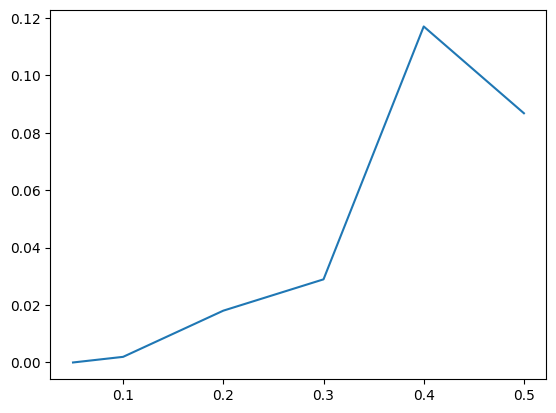

In [13]:
cfls = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
peakpressure = []
L2 = []

c0p05 = np.load(r"2DConvergence/GroundTruth_slice0.05focused0p5mmonepulse_PeakPressure.npy")
for c in cfls:
    pp = np.load(r"2DConvergence/GroundTruth_slice"+str(c)+"focused0p5mmonepulse_PeakPressure.npy")
    peakpressure.append(np.sum(pp)/np.sum(c0p05))
    #c0p05 = peakpressure[0]
    L2.append(np.sum((c0p05 - pp) ** 2)/np.sum(c0p05 ** 2)*100)
    print(np.sum(pp))
plt.plot(cfls,L2)